# Random Forest Model With Beach Gaze Data From Full Study - With Contamination*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Important: Double check your file paths and folder structure

In [2]:
# Using each users' eye tracking data from the entire test
# Get the project root directory
# Try to find project root by looking for "Full DGMs Unorganized" folder
current_dir = os.getcwd()
project_root = current_dir

# Navigate up to find project root (where "Full DGMs Unorganized" exists)
for _ in range(3):  # Check up to 3 levels up
    if os.path.exists(os.path.join(current_dir, "Full DGMs Unorganized")):
        project_root = current_dir
        break
    parent = os.path.dirname(current_dir)
    if parent == current_dir:  # Reached filesystem root
        break
    current_dir = parent

# Data folder: Full DGMs Unorganized (at project root)
data_folder = os.path.join(project_root, "Full DGMs Unorganized")

# Path to literacy results CSV (relative to project root)
target_csv_path = os.path.join(project_root, "Code", "Utilities", "users_literacy_results.csv")

# Print paths for verification
print(f"Project root: {project_root}")
print(f"Data folder: {data_folder}")
print(f"CSV path: {target_csv_path}")

# Load target values
y = pd.read_csv(target_csv_path)['LITERACY']

Project root: c:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research
Data folder: c:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\Full DGMs Unorganized
CSV path: c:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\Code\Utilities\users_literacy_results.csv


In [3]:
# Grab all 30 CSV files for training excluding user 5 and 20
# New structure: Full DGMs Unorganized/user_X/User X_fixations_DGMs.csv
csv_files = []
for user_id in range(1, 33):
    # Skip user 5 and user 20
    if user_id == 5 or user_id == 20:
        continue

    # user_X folder in Full DGMs Unorganized
    user_folder = os.path.join(data_folder, f"user_{user_id}")

    if os.path.exists(user_folder):
        # Look for DGM file in the user folder
        # The DGM file should be named: User X_fixations_DGMs.csv
        for file in os.listdir(user_folder):
            if file.endswith("_DGMs.csv") and "fixations" in file:
                file_path = os.path.join(user_folder, file)
                csv_files.append(file_path)
                break

# Print collected files for verification
print(f"Collected {len(csv_files)} CSV files.")


Collected 30 CSV files.


In [4]:
csv_files

['c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Full DGMs Unorganized\\user_1\\User 1_fixations_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Full DGMs Unorganized\\user_2\\User 2_fixations_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Full DGMs Unorganized\\user_3\\User 3_fixations_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Full DGMs Unorganized\\user_4\\User 4_fixations_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Full DGMs Unorganized\\user_6\\User 6_fixations_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Full DGMs Unorganized\\user_7\\User 7_fixations_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Full DGMs Unorganized\\user_8\\User 8_fixations_DGMs.csv',
 'c:\\Users\\tonyg\\OneDriv

In [5]:
# List to store feature data
feature_data = []
column_names = None  

# Identify the columns without NaNs using the first CSV file
# Question: Should we also drop the columns with all 0's?
df_sample = pd.read_csv(csv_files[0])  
valid_columns = df_sample.columns[~df_sample.isna().any()].tolist()  # Only keep columns without NaNs

# Load all users' data using only valid columns
for file in csv_files:
    df = pd.read_csv(file)

    df_clean = df[valid_columns]

    # Append feature data
    feature_data.append(df_clean.iloc[0].values)  

In [6]:
# Convert feature data to DataFrame
X = pd.DataFrame(feature_data, columns=valid_columns)

In [7]:
X.head()

,total_number_of_fixations,sum_of_all_fixation_duration_s,mean_fixation_duration_s,median_fixation_duration_s,stdev_of_fixation_durations_s,min_fixation_duration_s,max_fixation_duration_s,total_number_of_saccades,sum_of_all_saccade_lengths,mean_saccade_length,...,max_relative_degree,convex_hull_area,stationary_entropy,transition_entropy,total_number_of_blinks,total_number_of_valid_recordings,average_pupil_size_of_left_eye,average_pupil_size_of_right_eye,average_pupil_size_of_both_eyes,total_number_of_l_mouse_clicks
0,3161.0,591.64406,0.187170,0.16748,0.090859,0.01880,0.77612,3142.0,464344.655307,147.786332,...,179.515045,1.035234e+06,0.0,0.0,0.0,3161.0,2.338190,2.523856,2.431023,5.0
1,1894.0,679.99283,0.359025,0.31360,0.158426,0.04419,1.33582,1890.0,421366.852541,222.945425,...,179.218439,9.905146e+05,0.0,0.0,28.0,1894.0,3.396457,3.371411,3.383934,3.0
2,6166.0,1364.77337,0.221339,0.19214,0.129310,0.01453,1.53394,6097.0,956202.171443,156.831585,...,179.536361,1.334820e+06,0.0,0.0,0.0,6166.0,4.602307,4.548010,4.575158,4.0
3,3184.0,825.92603,0.259399,0.22119,0.157296,0.02020,1.79993,3181.0,426758.739495,134.158673,...,178.943853,7.619740e+05,0.0,0.0,0.0,3184.0,2.867069,2.911423,2.889246,1.0
4,1700.0,554.32693,0.326075,0.29639,0.143436,0.04639,1.69629,1692.0,412313.275792,243.683969,...,179.194458,1.502547e+06,0.0,0.0,58.0,1700.0,3.278416,3.461569,3.369993,4.0


In [8]:
X.shape

(30, 51)

In [9]:
y.head()

0    1
1    0
2    0
3    1
4    0
Name: LITERACY, dtype: int64

In [10]:
y.shape

(30,)

In [11]:
# Define the Random Forest pipeline
rf_model = Pipeline([
    ("scaler", StandardScaler()), # Scale features
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])

In [14]:
# Perform 10-fold cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=10, scoring="accuracy")

In [15]:
# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")

Cross-validation scores: [0.66666667 1.         0.66666667 0.66666667 0.33333333 1.
 0.33333333 0.         1.         1.        ]
Mean accuracy: 0.6667
Standard deviation: 0.3333


In [16]:
# Perform Leave-One-Out CV
loo = LeaveOneOut()

loo_cv_scores = cross_val_score(rf_model, X, y, cv=loo, scoring='accuracy')

In [17]:
print(f"LOOCV Scores: {loo_cv_scores}")
print(f"Mean accuracy: {np.mean(loo_cv_scores):.4f}")
print(f"Standard deviation: {np.std(loo_cv_scores):.4f}")

LOOCV Scores: [1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1.]
Mean accuracy: 0.5667
Standard deviation: 0.4955


Did worse than logistic regression on LOO

In [18]:
# Split into train and test with an 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [19]:
print("Training Set Shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing Set Shape (X_test, y_test):", X_test.shape, y_test.shape)

Training Set Shape (X_train, y_train): (21, 51) (21,)
Testing Set Shape (X_test, y_test): (9, 51) (9,)


In [20]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

In [21]:
y_pred = rf_model.predict(X_test)

In [22]:
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.3333333333333333

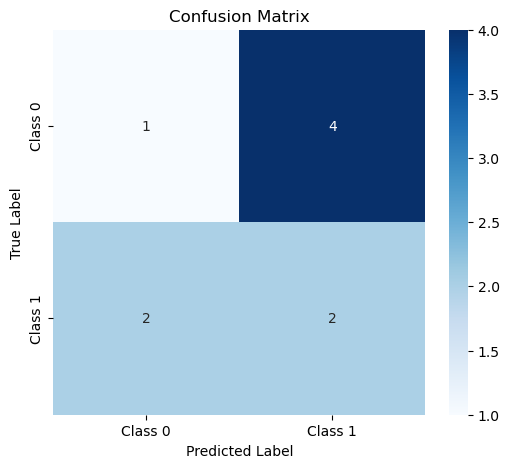

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"], 
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:
class_report = classification_report(y_test, y_pred)

print(class_report)

              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.33      0.50      0.40         4

    accuracy                           0.33         9
   macro avg       0.33      0.35      0.33         9
weighted avg       0.33      0.33      0.32         9



# Hyperparameter tuning

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [26]:
# Define the hyperparameter grid
param_dist = {
    "n_estimators": [50, 100, 200, 500], # Number of trees
    "max_depth": [None, 10, 20, 30, 50], # Tree depth
    "min_samples_split": [2, 5, 10], # Minimum samples per split
    "min_samples_leaf": [1, 2, 4], # Minimum samples per leaf
    "max_features": ["sqrt", "log2"], # Feature selection per tree split
    "bootstrap": [True, False], # Whether to bootstrap samples
}

In [27]:
# Init the Random Forest Model
rf = RandomForestClassifier(random_state=42)

In [28]:
# Use RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20, cv=5, scoring="accuracy", n_jobs=-1, verbose=2, random_state=42
)

In [29]:
# Fit Randomized Search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=42, scoring='accuracy', verbose=2)

In [30]:
# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [31]:
best_rf = RandomForestClassifier(**random_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [32]:
# Perform 10-fold cross-validation with the best Random Forest model
cv_scores = cross_val_score(best_rf, X, y, cv=10, scoring="accuracy")

In [33]:
# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")

Cross-validation scores: [0.66666667 1.         0.33333333 1.         0.66666667 0.66666667
 0.66666667 0.         1.         1.        ]
Mean accuracy: 0.7000
Standard deviation: 0.3145


Barely better than original RF